In [32]:
import networkx as nx 
import matplotlib.pyplot as plt 
import numpy
import csv
import gurobipy as grb
import copy
import time

In [3]:
n=10 #number of nodes of the graph
prob=0.3 #Edge density: Between 0 and 1
no_of_tran=1500 #number of transaction between each pair of sender and reciever 
M_vector=numpy.array([5,10,20,50,100]) #Capacity of each link in the graph
numpy.random.seed(1)

# Generate a Bidirected graph with specified # of nodes and edge density 

Erdos Renyi Random Graph

In [5]:
numpy.random.seed(1)
random_G= nx.erdos_renyi_graph(n,prob) #Generate an Erdos Renyi Random Graph with n nodes and probability of an edge p
uni_edges=random_G.edges
numpy.savetxt('medium_graph.csv', (uni_edges), delimiter=',') #Saving the edges of the generated graph in a csv file

#Now, we will convert the graph into a bidirectional graph by adding edges in the opposite direction
rows=len(uni_edges) #Number of edges in the generated graph
col=2 #Source and Destination tuple of each edge
bi_edges=numpy.zeros((2*rows,col)) #double the number of edges of G
with open('medium_graph.csv') as csvDataFile: #Reading the csv file to import the edges of G
    p=csv.reader(csvDataFile)
    p=list(p)
    for i in range(0,col):
        for j in range(0,rows):
            bi_edges[j,i]=p[j][i]
    for i in range(0,col): 
        for j in range(rows,2*rows):
            bi_edges[j,i]=bi_edges[j-rows,(i+1)%2] #Adding edges in the opposite direction
bi_edges=numpy.array(bi_edges)
bi_edges=bi_edges.astype(int)

#Generate a bidirectional graph with bi_edges
w=numpy.ones((2*rows))
bi_G = nx.DiGraph()
for i in range(0,2*rows):
    bi_G.add_weighted_edges_from([(bi_edges[i,0], bi_edges[i,1],w[i])]) #Adding bi_edges to the graph with weights w

# Generating Poisson Random Transaction Requests

- First, generate circular transaction rates 
- Then, Generate no_of_tran Poisson Transaction requests between each pair of nodes with the specified rate
- Finally, randomize the order of transaction requests to generate the final data set


In [6]:
numpy.random.seed(1)
#Generating the circular transaction rate matrix
I=numpy.identity(n)
P=numpy.zeros((n,n))
for i in range(0,n*3):
    P=P+numpy.random.permutation(I)
for i in range(0,n):
    P[i,i]=0
#Generating no_of_tran number of transactions between each pair of nodes
tran=numpy.array([0,11,1]) #initialize transaction array (this row will be deleted later)
for k in range(0,no_of_tran):
    for i in range(0,n):
        for j in range(0,n):
            if i!=j:
                x=numpy.random.poisson(P[i,j]) #Generating random transaction request from i to j
                if x>0:
                    New_tran=numpy.array([i,j,x]) #saving the new transaction as sender-reciever-value
                    tran=numpy.vstack((tran,New_tran)) #adding the new transaction to the list
tran=numpy.delete(tran,obj=0,axis=0) #deleting the first row 
numpy.random.shuffle(tran) #shuffling the transaction order
print(P)

[[0. 0. 5. 1. 3. 4. 4. 3. 5. 3.]
 [2. 0. 0. 5. 5. 3. 3. 5. 1. 4.]
 [2. 3. 0. 5. 2. 5. 5. 3. 1. 1.]
 [5. 1. 3. 0. 3. 2. 5. 2. 2. 5.]
 [5. 4. 3. 1. 0. 3. 3. 3. 3. 3.]
 [7. 4. 3. 3. 3. 0. 2. 1. 4. 3.]
 [1. 8. 2. 6. 3. 4. 0. 1. 2. 2.]
 [1. 2. 3. 2. 3. 6. 2. 0. 3. 2.]
 [3. 4. 5. 0. 4. 0. 4. 1. 0. 4.]
 [2. 2. 3. 5. 2. 3. 1. 5. 4. 0.]]


# Finding the minimum weighted path in a given graph G from s to d

In [36]:
def minwp(G,s,d,tran):
    start_time=time.time()
    min_wei_path=0 #initialize the minimum weighted path to 0
    X=nx.all_simple_paths(G,s,d) #Enumerating all the paths from s to d
    weight2=1000 #Intitialize by a very big number
    for j, a in enumerate(X): #a is a path from s to d
        weight1=0 #Initialize to calculate weight of a
        for k in range(0,len(a)-1):
            weight1=weight1+G[a[k]][a[k+1]]['weight']-G[a[k+1]][a[k]]['weight'] #calculate the total weight of 'a'
        if min(weight1,weight2)==weight1 and weight1!=weight2: #compare with the best weight obtained so far
            min_wei_path=a #update the minimum weighted path
            weight2=weight1 #update the best weight obtained so far
    var=1
    for l in range(0,len(min_wei_path)-1):
        s=min(G[min_wei_path[l]][min_wei_path[l+1]]['weight'],G[min_wei_path[l+1]][min_wei_path[l]]['weight'],M)
        if G[min_wei_path[l]][min_wei_path[l+1]]['weight']+tran-s>M: 
            #Checking if a has enough capacity to route tran
            var=0
    if var!=0:
        return (min_wei_path,time.time()-start_time) #We will either get a path from s to d or 0 if min_wei_path cannot route tran
    else:
        return (0,time.time()-start_time)

# Routing tran using path

In [8]:
def UpdateWeights(G,path,tran):
    for i in range(0,len(path)-1):
        s=min(G[path[i]][path[i+1]]['weight'],G[path[i+1]][path[i]]['weight'],M) #calculating the amount of service
        G[path[i]][path[i+1]]['weight']=G[path[i]][path[i+1]]['weight']+tran-s
        G[path[i+1]][path[i]]['weight']=G[path[i+1]][path[i]]['weight']-s
    return G

# Main Loop

In [39]:
for argument in range(0,len(M_vector)):
    M=M_vector[argument]
    no_of_succ_tran=0
    amount_of_succ_tran=0
    total_buffer=0
    min_wei_path=0
    t=0
    total_time=0
    start_time=time.time()
    for k in range(0,len(bi_edges)):
        bi_G[bi_edges[k,0]][bi_edges[k,1]]['weight']=0.01/len(bi_edges) #initializing the weights
        bi_G[bi_edges[k,0]][bi_edges[k,1]]['imbalance']=0 #initializing the imbalance
    for i in range(0,len(tran)):
        if min_wei_path!=0:
            bi_G=UpdateWeights(bi_G,min_wei_path,0) #Balancing the outstanding balance from prev transaction
            #Ideally, you would clear out the buffer on all the edges but we do it only for the edges for which 
            #there can be some outstanding balance to optimize the run time of the code
        (min_wei_path,t)=minwp_heu(bi_G,tran[i,0],tran[i,1],float(tran[i,2]),1) #finding the minimum weighted path from sender to reciever
        total_time=total_time+t
        if min_wei_path!=0: #If a path exists
            bi_G=UpdateWeights(bi_G,min_wei_path,tran[i,2]) #Route the transaction using min_wei_path
            no_of_succ_tran=no_of_succ_tran+1
            amount_of_succ_tran=amount_of_succ_tran+tran[i,2]
    for i in range(0,len(bi_edges)):
        total_buffer=total_buffer+bi_G[bi_edges[i,0]][bi_edges[i,1]]['weight']
    print("no_of_succ_tran:", no_of_succ_tran, "amount_of_succ_tran:", amount_of_succ_tran,
         "total_buffer:", total_buffer, "M:",M, "time:", total_time)

no_of_succ_tran: 53487 amount_of_succ_tran: 124453 total_buffer: 46.0 M: 5 time: 8.062795877456665
no_of_succ_tran: 77930 amount_of_succ_tran: 231295 total_buffer: 72.0 M: 10 time: 7.883580207824707
no_of_succ_tran: 89219 amount_of_succ_tran: 282849 total_buffer: 149.0 M: 20 time: 7.9091267585754395
no_of_succ_tran: 93451 amount_of_succ_tran: 302207 total_buffer: 447.0 M: 50 time: 7.813626766204834
no_of_succ_tran: 94119 amount_of_succ_tran: 305379 total_buffer: 954.0 M: 100 time: 8.00032114982605


# Solving the Fluid Model

In [13]:
max_number_paths=max(max(len(list(nx.all_simple_paths(bi_G,i,j))) for i in range(0,n)) for j in range(0,n))
list_p=numpy.ones((n,n,max_number_paths,n))*-1
for i in range(0,n):
    for j in range(0,n):
        k=0
        for path in nx.all_simple_paths(bi_G,i,j):
            for l in range(0,len(path)):
                list_p[i,j,k,l]=path[l] #Enumerating all paths in the graph as an array
            k=k+1
def paths(list_p,u,v): #Finding all the paths that has edge (u,v)
    x=[]
    for i in range(0,n):
        for j in range(0,n):
            for k in range(0,max_number_paths):
                for l in range(0,n-1):
                    if list_p[i,j,k,l]==u and list_p[i,j,k,l+1]==v:
                        x.append([i,j,k])
    return(x)
opt_model = grb.Model(name="Fluid Model")
x_vars  ={(i,j,p):opt_model.addVar(vtype=grb.GRB.CONTINUOUS, lb=0, name="x_{0}_{1}_{2}".format(i,j,p)) 
for i in range(0,n) for j in range(0,n) for p in range(0,max_number_paths)}
constraints = {(i,j) : opt_model.addConstr(lhs=grb.quicksum(x_vars[i,j,p] for p in range(0,max_number_paths)),
        sense=grb.GRB.EQUAL,rhs=P[i,j], name="rate_equal_to_demand".format(i,j))for i in range(0,n) 
               for j in range(0,n)}
for i in range(0,int(len(bi_edges)/2)):
    path_given_edge=numpy.array(paths(list_p,bi_edges[i,0],bi_edges[i,1]))
    path_opp_edge=numpy.array(paths(list_p,bi_edges[i,1],bi_edges[i,0]))
    opt_model.addConstr(lhs=grb.quicksum(x_vars[path_given_edge[j,0],path_given_edge[j,1]
            ,path_given_edge[j,2]] for j in range(0,len(path_given_edge))),
        sense=grb.GRB.LESS_EQUAL,rhs=M, name="capacity".format(i))
    opt_model.addConstr(lhs=grb.quicksum(x_vars[path_given_edge[j,0],path_given_edge[j,1]
            ,path_given_edge[j,2]] for j in range(0,len(path_given_edge))),
        sense=grb.GRB.EQUAL,rhs=grb.quicksum(x_vars[path_opp_edge[j,0],path_opp_edge[j,1]
            ,path_opp_edge[j,2]] for j in range(0,len(path_given_edge))), name="flow_balance".format(i))
objective = grb.quicksum(x_vars[i,j,p] for i in range(0,n) for j in range(0,n) for p in range(0,max_number_paths))
opt_model.setObjective(objective)
opt_model.ModelSense = grb.GRB.MAXIMIZE
opt_model.optimize()
x_fluid=numpy.zeros((n,n,max_number_paths))
i=0
j=0
p=0
for v in opt_model.getVars():
    x_fluid[i,j,p]=v.x
    if j==n-1 and p==max_number_paths-1:
        i=(i+1)
    if p==max_number_paths-1:
        j=(j+1)%n
    p=(p+1)%max_number_paths

Using license file /Users/sushilvarma/gurobi.lic
Academic license - for non-commercial use only
Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (mac64)
Optimize a model with 124 rows, 700 columns and 3445 nonzeros
Model fingerprint: 0xb805e1c4
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+02]
Presolve removed 18 rows and 228 columns
Presolve time: 0.01s
Presolved: 106 rows, 472 columns, 3097 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.7400000e+02   1.520013e+03   0.000000e+00      0s
     235    2.7400000e+02   0.000000e+00   0.000000e+00      0s

Solved in 235 iterations and 0.02 seconds
Optimal objective  2.740000000e+02


# Randomizing the path for Spider (According to the fluid solution)

In [40]:
def spider_path(G,x_fluid,s,d,tran):
    start_time=time.time()
    rand=numpy.random.uniform(0,1)
    path=[-1]
    path_output=[]
    for p in range(0,max_number_paths):
        if rand<x_fluid[s,d,p]/P[s,d]:
            path=list_p[s,d,p]
            break
        else:
            rand=rand-x_fluid[s,d,p]/P[s,d]
    var=-1
    for l in range(0,len(path)-1):
        if path[l+1]!=-1:
            s=min(G[path[l]][path[l+1]]['weight'],G[path[l+1]][path[l]]['weight'],M)
            if G[path[l]][path[l+1]]['weight']+tran-s>M: 
            #Checking if path has enough capacity to route tran
                var=0
    if var!=0:
        for i in range(0,n):
            if path[i]!=-1:
                path_output.append(path[i])
        return (path_output,time.time()-start_time)
    else:
        return ([],time.time()-start_time)

# Main Loop: Spider

In [41]:
for argument in range(0,len(M_vector)):
    M=M_vector[argument]
    no_of_succ_tran=0
    amount_of_succ_tran=0
    total_buffer=0
    min_wei_path=[]
    t=0
    total_time=0
    start_time=time.time()
    for repeat in range(0,1):
        for k in range(0,len(bi_edges)):
            bi_G[bi_edges[k,0]][bi_edges[k,1]]['weight']=0.01/len(bi_edges) #initializing the weights
            bi_G[bi_edges[k,0]][bi_edges[k,1]]['imbalance']=0 #initializing the imbalance
        for i in range(0,len(tran)):
            if min_wei_path!=[]:
                bi_G=UpdateWeights(bi_G,min_wei_path,0) #Balancing the outstanding balance from prev transaction
                #Ideally, you would clear out the buffer on all the edges but we do it only for the edges for which 
                #there can be some outstanding balance to optimize the run time of the code
            (min_wei_path,t)=spider_path(bi_G,x_fluid,tran[i,0],tran[i,1],float(tran[i,2])) #finding the minimum weighted path from sender to reciever
            total_time=total_time+t
            if min_wei_path!=[]: #If a path exists
                bi_G=UpdateWeights(bi_G,min_wei_path,tran[i,2]) #Route the transaction using min_wei_path
                no_of_succ_tran=no_of_succ_tran+1
                amount_of_succ_tran=amount_of_succ_tran+tran[i,2]
        for i in range(0,len(bi_edges)):
            total_buffer=total_buffer+bi_G[bi_edges[i,0]][bi_edges[i,1]]['weight']
    print("no_of_succ_tran:", no_of_succ_tran/(repeat+1), "amount_of_succ_tran:", amount_of_succ_tran/(repeat+1),
             "total_buffer:", total_buffer/(repeat+1), "M:",M, "time:", total_time/(repeat+1))

no_of_succ_tran: 8661.0 amount_of_succ_tran: 17888.0 total_buffer: 53.0 M: 5 time: 13.698929786682129
no_of_succ_tran: 10789.0 amount_of_succ_tran: 30668.0 total_buffer: 88.0 M: 10 time: 13.76298451423645
no_of_succ_tran: 70078.0 amount_of_succ_tran: 204089.0 total_buffer: 150.0 M: 20 time: 14.020827770233154
no_of_succ_tran: 92296.0 amount_of_succ_tran: 298813.0 total_buffer: 341.0 M: 50 time: 13.52838134765625
no_of_succ_tran: 104240.0 amount_of_succ_tran: 352707.0 total_buffer: 674.0 M: 100 time: 13.65138840675354


# Finding the minimum weighted path in a given graph G from s to d

- Using the Heuristic: Find K- Shortest path using the positive part of the weights and pick the path among these which has the lowest total weight

In [38]:
def minwp_heu(G,s,d,tran,K):
    start_time=time.time()
    X=nx.shortest_simple_paths(G,s,d,'imbalance') 
    #returns a generator which returns one path at a time from shortest to longest
    weight2=100000 #initialize by a very large number
    for j, path in enumerate(X): #enumerate shortest to longest paths 
        weight1=0 #initialize by 0 to calculate the weight of path
        for k in range(0,len(path)-1):
            weight1=weight1+G[path[k]][path[k+1]]['weight']-G[path[k+1]][path[k]]['weight'] 
            #calculating the actual weight of path p
        if min(weight1,weight2)==weight1 and weight1!=weight2: #comparing with the best weight obtained so far
            min_wei_path=path #picking the minimum weight path
            weight2=weight1 #updating the best weight obtained so for
        if j == K-1: #break after looking at K shortest paths according to the imbalance
            break
    var=1
    for l in range(0,len(min_wei_path)-1):
        s=min(G[min_wei_path[l]][min_wei_path[l+1]]['weight'],G[min_wei_path[l+1]][min_wei_path[l]]['weight'],M)
        if G[min_wei_path[l]][min_wei_path[l+1]]['weight']+tran-s>M: 
            #Checking if a has enough capacity to route tran
            var=0
    if var!=0:
        return (min_wei_path,time.time()-start_time) #We will either get a path from s to d or 0 if min_wei_path cannot route tran
    else:
        return (0,time.time()-start_time)

In [387]:
no_of_succ_tran=0
for k in range(0,len(bi_edges)):
    bi_G[bi_edges[k,0]][bi_edges[k,1]]['weight']=0.01/len(bi_edges) #initializing the weights
for i in range(0,len(tran)):
    min_wei_path=minwp_heu(bi_G,tran[i,0],tran[i,1],float(tran[i,2]),1) #finding the minimum weighted path from sender to reciever
    if min_wei_path!=0: #If a path exists
        bi_G=UpdateWeights(bi_G,min_wei_path,float(tran[i,2])) #Route the transaction using min_wei_path
        no_of_succ_tran=no_of_succ_tran+1
print(no_of_succ_tran, "out of", i)

111029 out of 116563


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


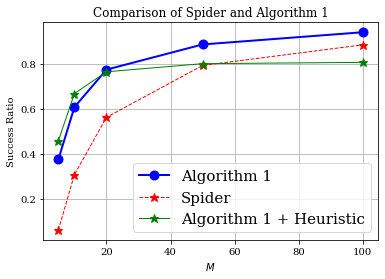

In [29]:
import matplotlib.pyplot as plt
import numpy
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.sans-serif'] = ['Computer Modern']
x=numpy.array([5,10,20,50,100])
y=numpy.array([43752,70891,90347,103432,109776])
z=numpy.array([7045.8,35820.0,65558.3,92518.6,103245.6])
w=numpy.array([53487,77930,89219,93451,94119])
plt.figure(1)
plt.plot(x,y/len(tran),'bo-', label='Algorithm 1', linewidth=2, markersize=9)
plt.plot(x, z/len(tran), 'r*--',label='Spider', linewidth=1, markersize=9)
plt.plot(x, w/len(tran), 'g*-',label='Algorithm 1 + Heuristic', linewidth=1, markersize=9)
plt.xlabel('$M$')
plt.ylabel('Success Ratio')
plt.title('Comparison of Spider and Algorithm 1')
plt.grid(True)
plt.legend(loc=4,prop={'size': 15})
plt.savefig("spidervsmaxweight.eps")
plt.show()

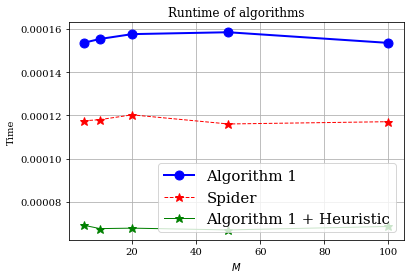

In [43]:
import matplotlib.pyplot as plt
import numpy
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.sans-serif'] = ['Computer Modern']
x=numpy.array([5,10,20,50,100])
y=numpy.array([17.91195011138916,18.114810705184937,18.374590635299683,18.476011514663696,17.901396989822388])
z=numpy.array([13.698929786682129,13.76298451423645,14.020827770233154,13.52838134765625,13.65138840675354])
w=numpy.array([8.062795877456665,7.883580207824707,7.9091267585754395,7.813626766204834,8.00032114982605])
plt.figure(1)
plt.plot(x,y/len(tran),'bo-', label='Algorithm 1', linewidth=2, markersize=9)
plt.plot(x, z/len(tran), 'r*--',label='Spider', linewidth=1, markersize=9)
plt.plot(x, w/len(tran), 'g*-',label='Algorithm 1 + Heuristic', linewidth=1, markersize=9)
plt.xlabel('$M$')
plt.ylabel('Time')
plt.title('Runtime of algorithms')
plt.grid(True)
plt.legend(loc=4,prop={'size': 15})
#plt.savefig("spidervsmaxweight.eps")
plt.show()